Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Device: cuda

Starting Training (Max 25 Epochs, Patience 5)...
Epoch 01 | Loss: 0.8976 | Val Loss: 0.9295 | Val Acc: 0.536 | Val AUC: 0.848
Epoch 02 | Loss: 0.6590 | Val Loss: 1.0329 | Val Acc: 0.513 | Val AUC: 0.854
Epoch 03 | Loss: 0.5697 | Val Loss: 0.9828 | Val Acc: 0.557 | Val AUC: 0.875
Epoch 04 | Loss: 0.5218 | Val Loss: 1.0100 | Val Acc: 0.586 | Val AUC: 0.875
Epoch 05 | Loss: 0.4815 | Val Loss: 1.0860 | Val Acc: 0.582 | Val AUC: 0.869
Epoch 06 | Loss: 0.4526 | Val Loss: 1.0887 | Val Acc: 0.604 | Val AUC: 0.871
Early stopping triggered at Epoch 6!


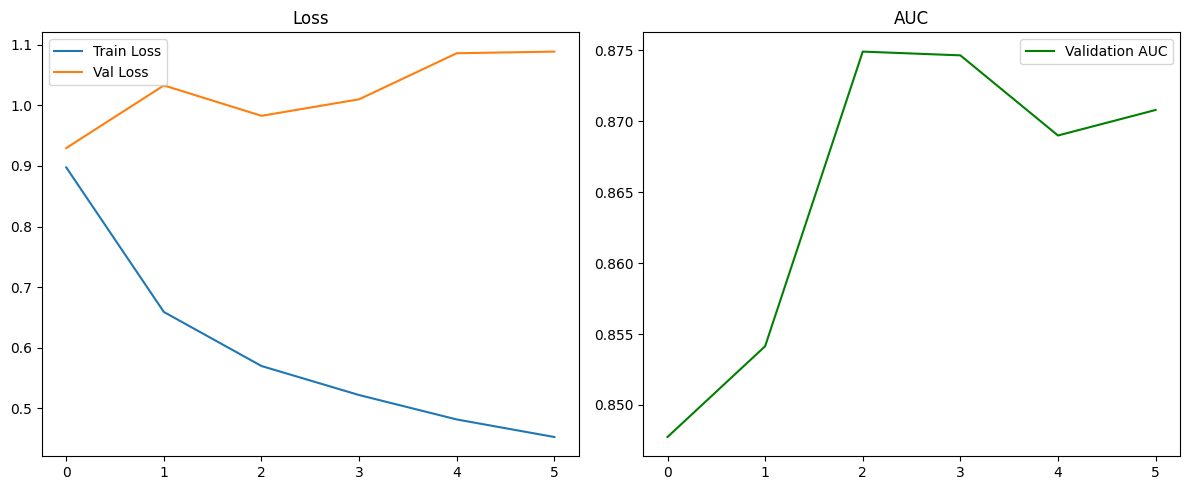


Loading Best Model for Final Test...
TEST RESULTS -> Acc: 0.636 | AUC: 0.722
              precision    recall  f1-score   support

      Normal       0.74      0.76      0.75        34
   Precancer       0.38      0.40      0.39        15
      Cancer       0.75      0.50      0.60         6

    accuracy                           0.64        55
   macro avg       0.62      0.55      0.58        55
weighted avg       0.64      0.64      0.64        55



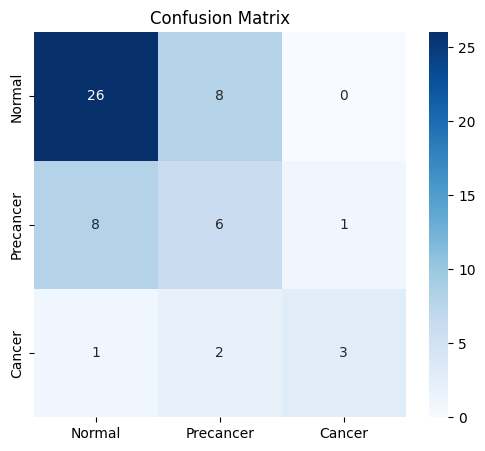

Model Saved.


In [ ]:
# ==============================================================================
# NOTEBOOK 2: MODEL TRAINING (v17 - FIXED: Acc + Early Stopping + Plots)
# ==============================================================================

import os
import re
import json
import time
import random
import zipfile
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as T
import timm
from pathlib import Path
from PIL import Image
from dataclasses import dataclass
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import GroupShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# 1. Setup
drive.mount('/content/drive')

# --- CONFIGURATION ---
@dataclass
class CFG:
    ZIP_PATH  = "/content/drive/MyDrive/MLProject/Cleaned_Dataset_Processed.zip"
    EXTRACT_TO = "/content/via_dataset_ready"

    TRAIN_DIR = os.path.join(EXTRACT_TO, "train")
    TEST_DIR  = os.path.join(EXTRACT_TO, "test")
    CSV_PATH  = "/content/drive/MyDrive/MLProject/labels_combine.csv"

    NUM_CLASSES: int = 3
    IMAGE_SIZE: int = 384
    BATCH_SIZE: int = 32
    EPOCHS: int = 25  # Increased limit, Early Stopping handles the rest

    LR: float = 1e-5

    SEED: int = 42
    MODEL_NAME: str = "efficientnet_b0"
    OUT_DIR: str = "runs"

    # Regularization
    DROPOUT_RATE: float = 0.5
    DROP_PATH_RATE: float = 0.2
    PATIENCE: int = 5   # Stop if no improvement for 5 epochs

    ZOOM_FACTOR: float = 0.65

cfg = CFG()

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(cfg.SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# 2. Extract Data
if os.path.exists(cfg.EXTRACT_TO):
    import shutil
    shutil.rmtree(cfg.EXTRACT_TO)

with zipfile.ZipFile(cfg.ZIP_PATH, 'r') as z:
    z.extractall(cfg.EXTRACT_TO)

# 3. Data Preparation
def prepare_dataframes():
    master_df = pd.read_csv(cfg.CSV_PATH)
    label_map = dict(zip(master_df['filename'], master_df['label']))

    def scan_folder(folder_path):
        data = []
        if not os.path.exists(folder_path): return pd.DataFrame(data)
        for f in os.listdir(folder_path):
            if not f.lower().endswith('.jpg'): continue

            clean_name = re.sub(r'_aug_.*', '', Path(f).stem)
            original_key = f"{clean_name}.jpg"

            # Robust Patient ID extraction
            if "sample" in clean_name:
                patient_id = clean_name.split('_')[0]
            else:
                match = re.search(r"([0-9]+[A-Z]+|[A-Z]+[0-9]+)", clean_name)
                patient_id = match.group(0) if match else clean_name

            if original_key in label_map:
                data.append({
                    "path": os.path.join(folder_path, f),
                    "label": label_map[original_key],
                    "patient_id": patient_id
                })
        return pd.DataFrame(data)

    train_full_df = scan_folder(cfg.TRAIN_DIR)
    test_df = scan_folder(cfg.TEST_DIR)

    mapping = {"Normal": 0, "Precancerous": 1, "Cancerous": 2}

    train_full_df['class_num'] = train_full_df['label'].apply(lambda x: mapping.get(str(x).capitalize(), mapping.get(str(x), -1)))
    test_df['class_num'] = test_df['label'].apply(lambda x: mapping.get(str(x).capitalize(), mapping.get(str(x), -1)))

    train_full_df = train_full_df[train_full_df['class_num'] != -1]
    test_df = test_df[test_df['class_num'] != -1]

    # Validation Split
    gss = GroupShuffleSplit(n_splits=1, test_size=0.15, random_state=cfg.SEED)
    train_idx, val_idx = next(gss.split(train_full_df, groups=train_full_df['patient_id']))

    return train_full_df.iloc[train_idx].reset_index(drop=True), train_full_df.iloc[val_idx].reset_index(drop=True), test_df

# 4. Transforms (CLAHE + Zoom)
class ApplyCLAHE:
    def __init__(self, clip_limit=2.0): self.clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(8, 8))
    def __call__(self, img):
        l, a, b = cv2.split(cv2.cvtColor(np.array(img), cv2.COLOR_RGB2LAB))
        return Image.fromarray(cv2.cvtColor(cv2.merge((self.clahe.apply(l), a, b)), cv2.COLOR_LAB2RGB))

class AutoZoom:
    def __init__(self, keep=0.8): self.keep = keep
    def __call__(self, img):
        w, h = img.size
        nw, nh = int(w*self.keep), int(h*self.keep)
        return img.crop(((w-nw)//2, (h-nh)//2, (w+nw)//2, (h+nh)//2))

def get_transforms(sz):
    base = [ApplyCLAHE(3.0), AutoZoom(cfg.ZOOM_FACTOR)]
    return T.Compose(base + [T.RandomResizedCrop(sz, scale=(0.7, 1.0)), T.RandomHorizontalFlip(), T.RandomVerticalFlip(), T.ToTensor(), T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]), \
           T.Compose(base + [T.Resize((sz, sz)), T.CenterCrop(sz), T.ToTensor(), T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# 5. Dataset & EarlyStopping Class
class CervicalDataset(Dataset):
    def __init__(self, df, t=None): self.df = df; self.t = t
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        return self.t(Image.open(self.df.iloc[i]['path']).convert("RGB")) if self.t else Image.open(self.df.iloc[i]['path']).convert("RGB"), torch.tensor(self.df.iloc[i]['class_num'], dtype=torch.long)

class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# 6. Train/Val Functions
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    # Freeze BN to avoid destroying stats with small batches
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d): m.eval()

    losses = []
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        loss = criterion(model(x), y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return np.mean(losses)

@torch.no_grad()
def validate(model, loader, criterion):
    model.eval()
    losses, preds, targets, probs = [], [], [], []

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)

        losses.append(loss.item())
        preds.extend(logits.argmax(1).cpu().numpy())
        targets.extend(y.cpu().numpy())
        probs.extend(torch.softmax(logits, dim=1).cpu().numpy())

    # Calculate Metrics
    loss = np.mean(losses)
    acc = np.mean(np.array(preds) == np.array(targets))
    f1 = f1_score(targets, preds, average='macro')

    try: auc = roc_auc_score(targets, np.array(probs), multi_class='ovr', average='weighted')
    except: auc = 0.5

    return loss, acc, f1, auc, preds, targets

# 7. Main
def main():
    train_df, val_df, test_df = prepare_dataframes()
    train_tfms, val_tfms = get_transforms(cfg.IMAGE_SIZE)

    # Weighted Sampler
    counts = train_df['class_num'].value_counts().sort_index()
    weights = [1.0/counts[l] for l in train_df['class_num']]
    sampler = WeightedRandomSampler(weights, len(weights), replacement=True)

    loaders = {
        'train': DataLoader(CervicalDataset(train_df, train_tfms), batch_size=cfg.BATCH_SIZE, sampler=sampler, num_workers=2),
        'val': DataLoader(CervicalDataset(val_df, val_tfms), batch_size=cfg.BATCH_SIZE, shuffle=False, num_workers=2),
        'test': DataLoader(CervicalDataset(test_df, val_tfms), batch_size=cfg.BATCH_SIZE, shuffle=False, num_workers=2)
    }

    # Model Setup
    model = timm.create_model(cfg.MODEL_NAME, pretrained=True, num_classes=cfg.NUM_CLASSES, drop_path_rate=cfg.DROP_PATH_RATE)
    for p in model.parameters(): p.requires_grad = False

    # Unfreeze Parts
    for p in model.classifier.parameters(): p.requires_grad = True
    for p in model.blocks[-1].parameters(): p.requires_grad = True
    for p in model.blocks[-2].parameters(): p.requires_grad = True

    # Add Dropout to Head
    model.classifier = nn.Sequential(nn.Dropout(p=cfg.DROPOUT_RATE), nn.Linear(model.classifier.in_features, cfg.NUM_CLASSES))
    model = model.to(device)

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.LR, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg.EPOCHS)

    # Early Stopping Init
    early_stopper = EarlyStopping(patience=cfg.PATIENCE, delta=0.001)

    out_dir = Path(cfg.OUT_DIR) / f"exp_{time.strftime('%m%d_%H%M')}"
    out_dir.mkdir(parents=True, exist_ok=True)

    best_auc = -1.0
    history = {'train_loss': [], 'val_loss': [], 'val_auc': []}

    print(f"\nStarting Training (Max {cfg.EPOCHS} Epochs, Patience {cfg.PATIENCE})...")

    for epoch in range(1, cfg.EPOCHS + 1):
        t_loss = train_one_epoch(model, loaders['train'], criterion, optimizer)
        v_loss, v_acc, v_f1, v_auc, _, _ = validate(model, loaders['val'], criterion) # <--- FIXED: Unpacking 6 items
        scheduler.step()

        history['train_loss'].append(t_loss)
        history['val_loss'].append(v_loss)
        history['val_auc'].append(v_auc)

        print(f"Epoch {epoch:02d} | Loss: {t_loss:.4f} | Val Loss: {v_loss:.4f} | Val Acc: {v_acc:.3f} | Val AUC: {v_auc:.3f}")

        # Save Best
        if v_auc > best_auc:
            best_auc = v_auc
            torch.save(model.state_dict(), out_dir / "best_model.pth")

        # Check Early Stopping
        early_stopper(v_loss)
        if early_stopper.early_stop:
            print(f"Early stopping triggered at Epoch {epoch}!")
            break

    # --- PLOTTING ---
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['val_auc'], label='Validation AUC', color='green')
    plt.title('AUC')
    plt.legend()

    plt.tight_layout()
    plt.savefig(out_dir / "training_plots.png")
    plt.show()

    # --- FINAL TEST ---
    print("\nLoading Best Model for Final Test...")
    model.load_state_dict(torch.load(out_dir / "best_model.pth"))
    _, test_acc, test_f1, test_auc, preds, targets = validate(model, loaders['test'], criterion) # <--- FIXED Unpacking

    print(f"TEST RESULTS -> Acc: {test_acc:.3f} | AUC: {test_auc:.3f}")
    print(classification_report(targets, preds, target_names=["Normal", "Precancer", "Cancer"]))

    cm = confusion_matrix(targets, preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "Precancer", "Cancer"], yticklabels=["Normal", "Precancer", "Cancer"])
    plt.title('Confusion Matrix')
    plt.show()

    torch.save(model, "/content/drive/MyDrive/MLProject/final_model_full.pkl")
    print("Model Saved.")

if __name__ == "__main__":
    main()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda
Scanning Test Folder...
Found 55 test images.
Loading model from /content/drive/MyDrive/MLProject/final_model_full.pkl...

Running Inference...
----------------------------------------
TOTAL TEST IMAGES: 55
ACCEPTED (>= 75.0%): 34
EXCLUDED (< 75.0%):  21
----------------------------------------

Classification Report (High Confidence Only):
              precision    recall  f1-score   support

      Normal       0.75      0.96      0.84        25
   Precancer       0.00      0.00      0.00         7
      Cancer       1.00      0.50      0.67         2

    accuracy                           0.74        34
   macro avg       0.58      0.49      0.50        34
weighted avg       0.61      0.74      0.66        34



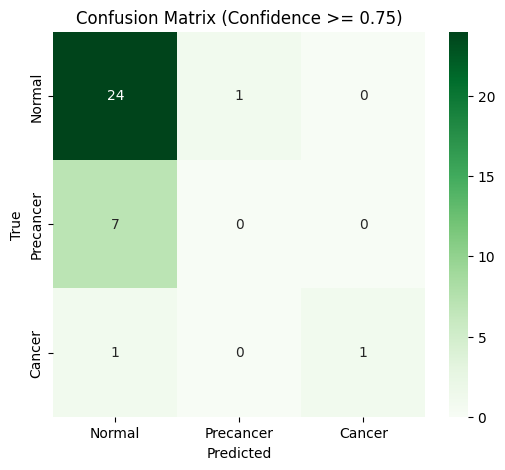


--- EXCLUDED CASES (Low Confidence) ---
Patient ID Confidence    Predicted         True
      AAH1     47.91%    Cancerous    Cancerous
      AAW1     51.52%       Normal       Normal
      ABV1     40.55%       Normal Precancerous
      ACN1     56.37% Precancerous       Normal
      ACQ1     69.70%       Normal Precancerous
      ADB1     74.51%       Normal Precancerous
      ADD1     72.68%       Normal Precancerous
      ADM1     58.89%       Normal Precancerous
      AEH1     63.47%       Normal Precancerous
      AEM1     56.14%       Normal    Cancerous
      AFA1     68.29%    Cancerous    Cancerous
      AFH1     74.58% Precancerous       Normal
      AGM1     74.32%       Normal       Normal
      AHD1     54.59% Precancerous       Normal
      AIO1     74.49% Precancerous       Normal
      AJW1     70.25%       Normal       Normal
      ANV1     60.90%       Normal       Normal
  sample25     70.73% Precancerous    Cancerous
   sample3     57.64%       Normal       Normal

In [ ]:
# ==============================================================================
# NOTEBOOK 3: HIGH-CONFIDENCE EVALUATION (Fixed for PyTorch 2.6+)
# ==============================================================================

import os
import re
import torch
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from google.colab import drive

# 1. Setup
drive.mount('/content/drive')

# --- CONFIGURATION ---
MODEL_PATH = "/content/drive/MyDrive/MLProject/final_model_full.pkl"
TEST_DIR = "/content/via_dataset_ready/test"
CSV_PATH = "/content/drive/MyDrive/MLProject/labels_combine.csv"
CONFIDENCE_THRESHOLD = 0.75  # 75%
IMAGE_SIZE = 384
ZOOM_FACTOR = 0.8

# --- CLASSES ---
class AutoZoom(object):
    def __init__(self, keep_percent=0.65):
        self.keep_percent = keep_percent
    def __call__(self, img):
        w, h = img.size
        new_w = int(w * self.keep_percent)
        new_h = int(h * self.keep_percent)
        left = (w - new_w)/2; top = (h - new_h)/2
        right = (w + new_w)/2; bottom = (h + new_h)/2
        return img.crop((left, top, right, bottom))

class ApplyCLAHE(object):
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8)):
        self.clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    def __call__(self, img):
        img_np = np.array(img)
        lab = cv2.cvtColor(img_np, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        cl = self.clahe.apply(l)
        limg = cv2.merge((cl, a, b))
        final = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
        return Image.fromarray(final)

class EvalDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['path']).convert("RGB")
        if self.transform: img = self.transform(img)
        return img, row['class_num'], row['patient_id']

# --- MAIN EVALUATION ---
def evaluate_model():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # 1. Load Dataframe (Test Set Only)
    master_df = pd.read_csv(CSV_PATH)
    label_map = dict(zip(master_df['filename'], master_df['label']))

    data = []
    if not os.path.exists(TEST_DIR):
        print("Error: Test directory not found. Please unzip data first.")
        # Optional: Uncomment if needed
        !unzip -q "/content/drive/MyDrive/ML Project/Cleaned_Dataset_Processed.zip" -d "/content/via_dataset_ready"
        return

    print("Scanning Test Folder...")
    for f in os.listdir(TEST_DIR):
        if not f.lower().endswith('.jpg'): continue

        # Regex to match augmented naming convention
        clean_name = re.sub(r'_aug_.*', '', Path(f).stem)
        original_key = f"{clean_name}.jpg"

        # Get Patient ID for reporting
        if "IARC" in clean_name:
            match = re.search(r"([0-9]+[A-Z]+|[A-Z]+[0-9]+)", clean_name)
            patient_id = match.group(0) if match else clean_name
        elif "sample" in clean_name:
            patient_id = clean_name.split('_')[0]
        else:
            patient_id = clean_name

        if original_key in label_map:
            data.append({
                "path": os.path.join(TEST_DIR, f),
                "label": label_map[original_key],
                "patient_id": patient_id
            })

    test_df = pd.DataFrame(data)
    mapping = {"Normal": 0, "Precancerous": 1, "Cancerous": 2}
    test_df['class_num'] = test_df['label'].apply(lambda x: mapping.get(str(x).capitalize(), -1))
    test_df = test_df[test_df['class_num'] != -1]

    print(f"Found {len(test_df)} test images.")

    # 2. Transforms (Must match Training exactly)
    eval_tfms = T.Compose([
        ApplyCLAHE(clip_limit=3.0),
        AutoZoom(keep_percent=ZOOM_FACTOR),
        T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        T.CenterCrop(IMAGE_SIZE),
        T.ToTensor(),
        T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])

    test_ds = EvalDataset(test_df, transform=eval_tfms)
    test_loader = DataLoader(test_ds, batch_size=16, shuffle=False)

    # 3. Load Model with Security Flag Disabled
    print(f"Loading model from {MODEL_PATH}...")

    # --- FIX IS HERE ---
    model = torch.load(MODEL_PATH, map_location=device, weights_only=False)
    # -------------------

    model.eval()

    # 4. Inference Loop
    high_conf_preds = []
    high_conf_targets = []
    excluded_cases = []

    print("\nRunning Inference...")

    with torch.no_grad():
        for imgs, targets, patient_ids in test_loader:
            imgs = imgs.to(device)
            logits = model(imgs)
            probs = torch.softmax(logits, dim=1)

            # Get max probability and predicted class
            max_probs, preds = torch.max(probs, dim=1)

            # CPU conversion
            max_probs = max_probs.cpu().numpy()
            preds = preds.cpu().numpy()
            targets = targets.numpy()

            for i in range(len(preds)):
                pid = patient_ids[i]
                confidence = max_probs[i]
                true_label = targets[i]
                pred_label = preds[i]

                # --- CONFIDENCE FILTER ---
                if confidence >= CONFIDENCE_THRESHOLD:
                    high_conf_preds.append(pred_label)
                    high_conf_targets.append(true_label)
                else:
                    excluded_cases.append({
                        'Patient ID': pid,
                        'Confidence': f"{confidence:.2%}",
                        'Predicted': list(mapping.keys())[pred_label],
                        'True': list(mapping.keys())[true_label]
                    })

    # 5. Results
    accepted_count = len(high_conf_preds)
    excluded_count = len(excluded_cases)
    total_count = accepted_count + excluded_count

    print("-" * 40)
    print(f"TOTAL TEST IMAGES: {total_count}")
    print(f"ACCEPTED (>= {CONFIDENCE_THRESHOLD*100}%): {accepted_count}")
    print(f"EXCLUDED (< {CONFIDENCE_THRESHOLD*100}%):  {excluded_count}")
    print("-" * 40)

    if accepted_count > 0:
        target_names = ["Normal", "Precancer", "Cancer"]
        print("\nClassification Report (High Confidence Only):")
        print(classification_report(high_conf_targets, high_conf_preds, target_names=target_names))

        # Confusion Matrix
        cm = confusion_matrix(high_conf_targets, high_conf_preds)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                    xticklabels=target_names, yticklabels=target_names)
        plt.title(f'Confusion Matrix (Confidence >= {CONFIDENCE_THRESHOLD})')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
    else:
        print("No images met the confidence threshold!")

    # 6. List Excluded Cases
    if excluded_cases:
        print("\n--- EXCLUDED CASES (Low Confidence) ---")
        excluded_df = pd.DataFrame(excluded_cases)
        # Sort by ID for readability
        excluded_df = excluded_df.sort_values('Patient ID')
        print(excluded_df.to_string(index=False))

        # Optional: Save to CSV
        excluded_df.to_csv("excluded_low_confidence_cases.csv", index=False)
        print("\nSaved list to 'excluded_low_confidence_cases.csv'")

if __name__ == "__main__":
    evaluate_model()


GROUP: True 'Cancerous' --> Predicted 'Cancerous'
Count: 2


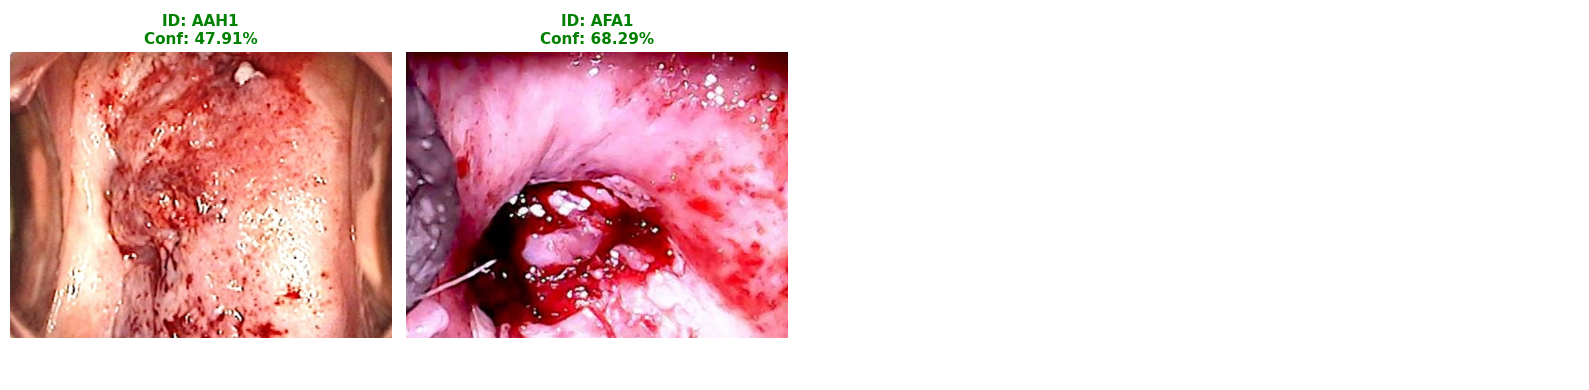


GROUP: True 'Cancerous' --> Predicted 'Normal'
Count: 1
Error loading AEM1: 'numpy.ndarray' object has no attribute 'imshow'


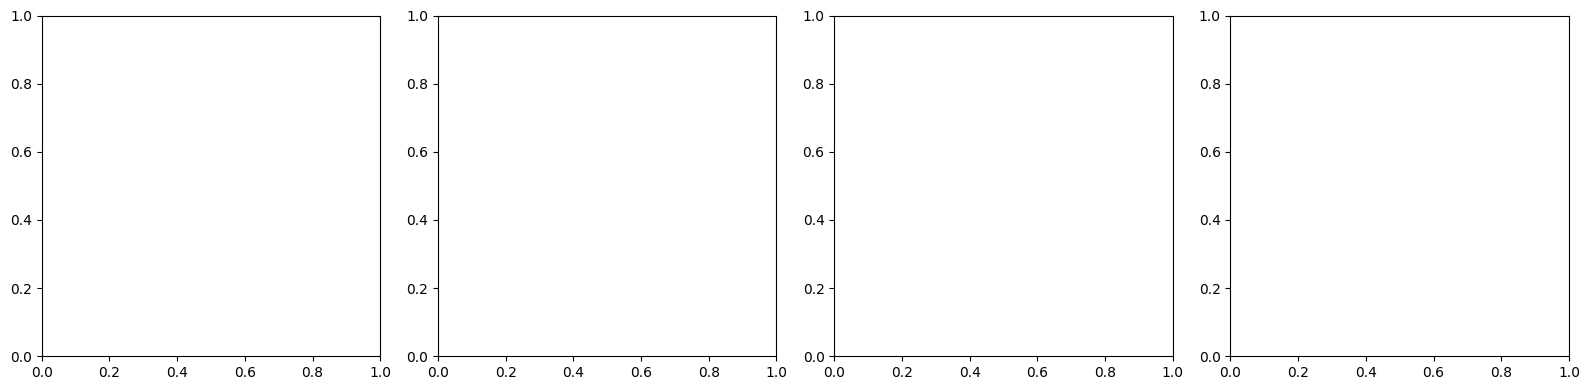


GROUP: True 'Cancerous' --> Predicted 'Precancerous'
Count: 1
Error loading sample25: 'numpy.ndarray' object has no attribute 'imshow'


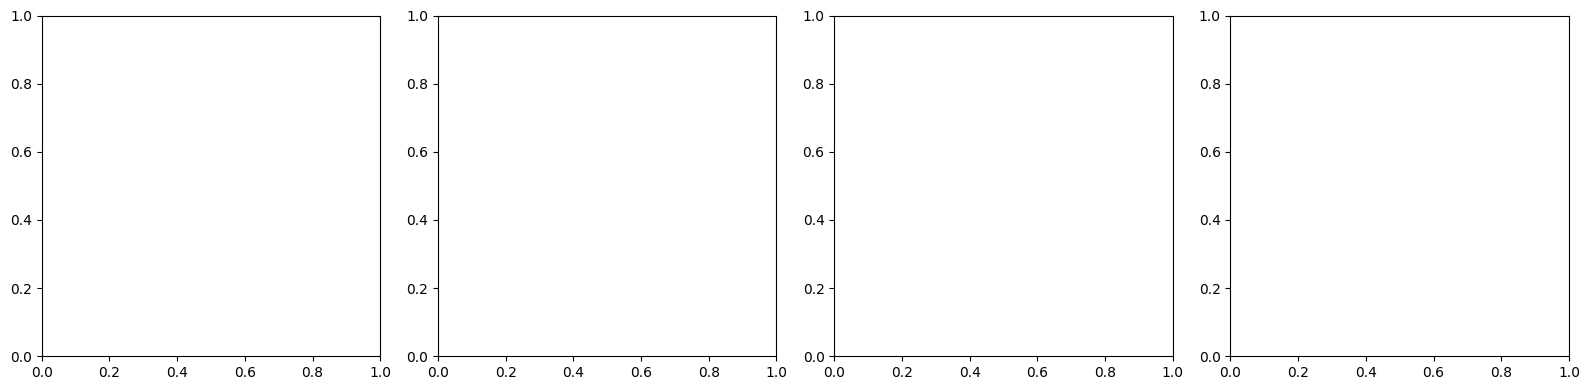


GROUP: True 'Normal' --> Predicted 'Normal'
Count: 5


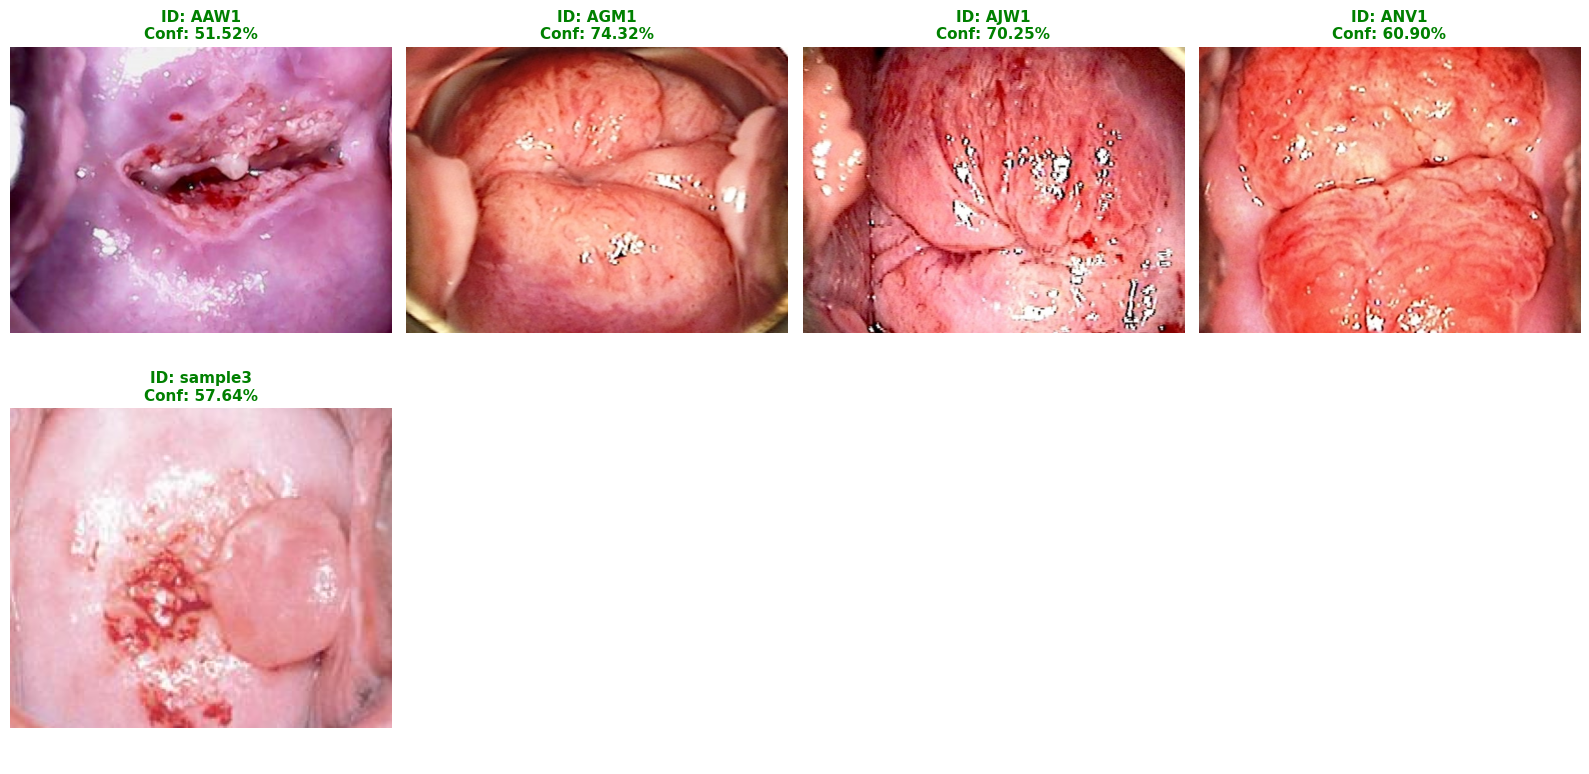


GROUP: True 'Normal' --> Predicted 'Precancerous'
Count: 4


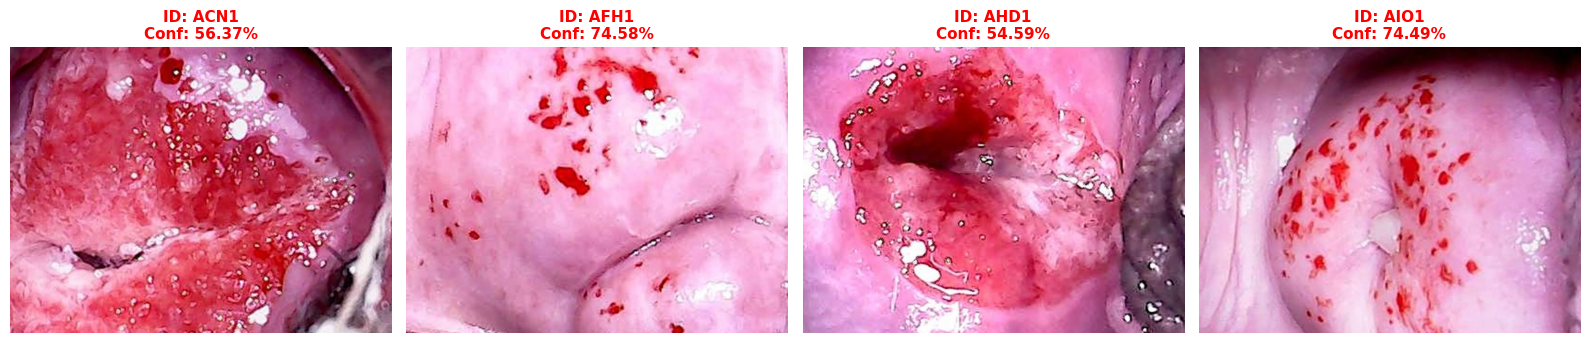


GROUP: True 'Precancerous' --> Predicted 'Normal'
Count: 8


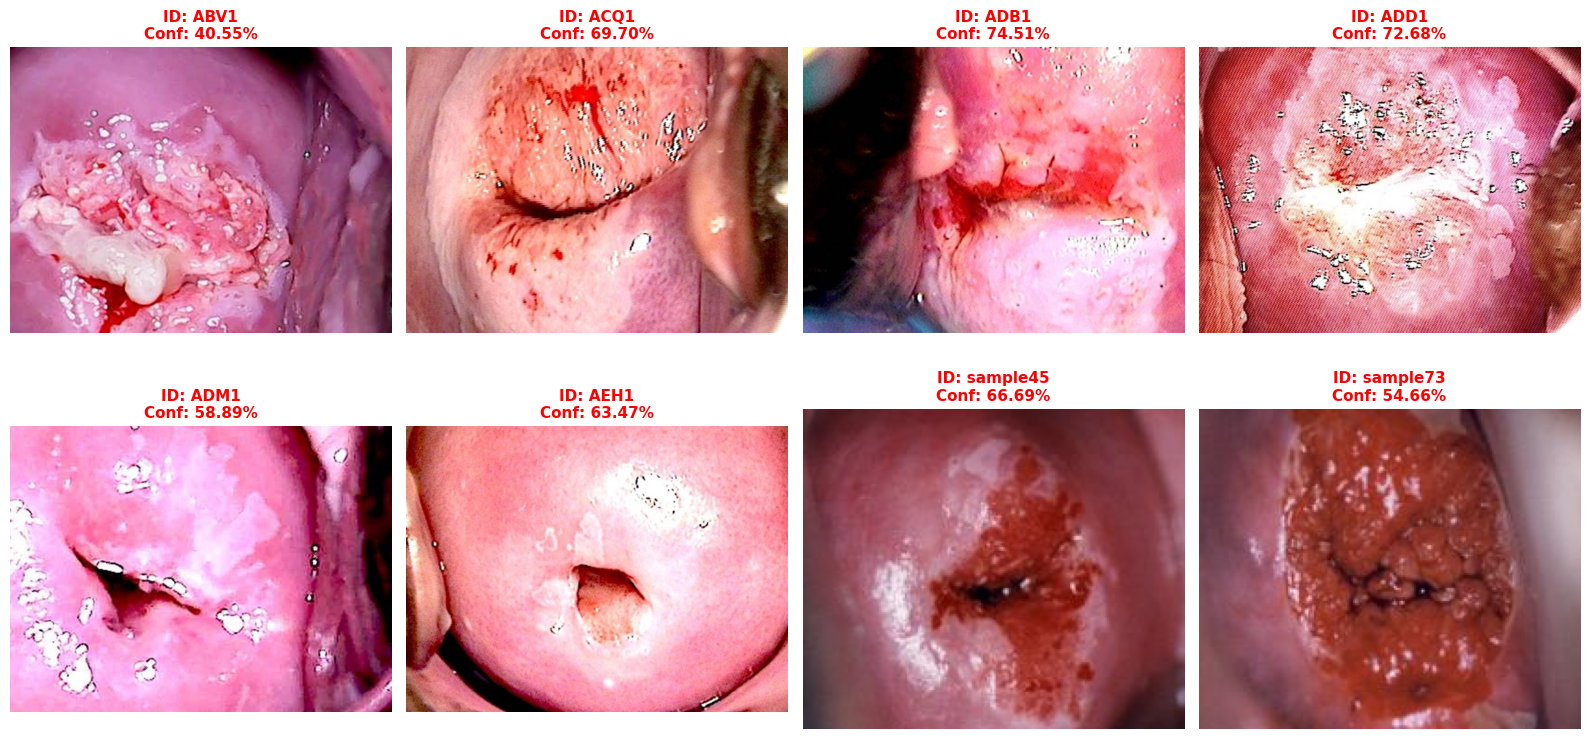

In [ ]:
import os
import re
import math
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

# --- CONFIGURATION ---
TEST_DIR = "/content/via_dataset_ready/test"
CSV_PATH = "excluded_low_confidence_cases.csv"
ZOOM_FACTOR = 0.65

class AutoZoom(object):
    def __init__(self, keep_percent=0.65):
        self.keep_percent = keep_percent
    def __call__(self, img):
        w, h = img.size
        new_w = int(w * self.keep_percent)
        new_h = int(h * self.keep_percent)
        left = (w - new_w)/2; top = (h - new_h)/2
        right = (w + new_w)/2; bottom = (h + new_h)/2
        return img.crop((left, top, right, bottom))

def display_grouped_errors():
    # 1. Load Data
    if not os.path.exists(CSV_PATH):
        print(f"Error: '{CSV_PATH}' not found.")
        return

    df = pd.read_csv(CSV_PATH)
    if len(df) == 0:
        print("No excluded cases to display.")
        return

    # 2. Map Files
    id_to_path = {}
    for f in os.listdir(TEST_DIR):
        if not f.lower().endswith('.jpg'): continue
        clean_name = re.sub(r'_aug_.*', '', Path(f).stem)

        # ID Extraction Logic
        if "IARC" in clean_name:
            match = re.search(r"([0-9]+[A-Z]+|[A-Z]+[0-9]+)", clean_name)
            pid = match.group(0) if match else clean_name
        elif "sample" in clean_name:
            pid = clean_name.split('_')[0]
        else:
            pid = clean_name

        if pid in df['Patient ID'].values:
            id_to_path[pid] = os.path.join(TEST_DIR, f)

    # 3. Group by (True Label -> Predicted Label)
    groups = {}
    for _, row in df.iterrows():
        key = (row['True'], row['Predicted'])
        if key not in groups:
            groups[key] = []
        groups[key].append(row)

    # 4. Display Logic
    zoomer = AutoZoom(keep_percent=ZOOM_FACTOR)

    # Sort keys for consistent order
    sorted_keys = sorted(groups.keys())

    for true_lbl, pred_lbl in sorted_keys:
        rows_data = groups[(true_lbl, pred_lbl)]

        # Header for the Group
        print("\n" + "="*60)
        print(f"GROUP: True '{true_lbl}' --> Predicted '{pred_lbl}'")
        print(f"Count: {len(rows_data)}")
        print("="*60)

        # Setup Grid
        num_imgs = len(rows_data)
        cols = 4
        rows = math.ceil(num_imgs / cols)

        fig, axes = plt.subplots(rows, cols, figsize=(16, 4 * rows))
        if num_imgs == 1: axes = [axes] # Handle single case
        else: axes = axes.flatten()

        # Plot each image in the group
        for i, row in enumerate(rows_data):
            pid = row['Patient ID']
            conf = row['Confidence']

            if pid in id_to_path:
                try:
                    img = Image.open(id_to_path[pid])
                    img = zoomer(img)

                    # Set color: Green if they match (just low conf), Red if error
                    color = 'green' if true_lbl == pred_lbl else 'red'

                    ax = axes[i]
                    ax.imshow(img)
                    ax.set_title(f"ID: {pid}\nConf: {conf}", fontsize=11, fontweight='bold', color=color)
                    ax.axis('off')
                except Exception as e:
                    print(f"Error loading {pid}: {e}")
            else:
                # Placeholder for missing file
                axes[i].text(0.5, 0.5, "File Not Found", ha='center')
                axes[i].axis('off')

        # Clear remaining empty axes in the grid
        for j in range(i + 1, len(axes)):
            axes[j].axis('off')

        plt.tight_layout()
        plt.show()

display_grouped_errors()